# Review analysis using Logistic Regression from scratch

In [12]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt

print("Libraries imported")

Libraries imported


In [9]:
products=pd.read_csv(r"amazon_baby_subset.csv")
print(products.head())
print("The columns are",products.columns.tolist()); print("shape of dataset is",products.shape)

                                                name  \
0  Stop Pacifier Sucking without tears with Thumb...   
1    Nature's Lullabies Second Year Sticker Calendar   
2    Nature's Lullabies Second Year Sticker Calendar   
3                        Lamaze Peekaboo, I Love You   
4  SoftPlay Peek-A-Boo Where's Elmo A Children's ...   

                                              review  rating  sentiment  
0  All of my kids have cried non-stop when I trie...       5          1  
1  We wanted to get something to keep track of ou...       5          1  
2  My daughter had her 1st baby over a year ago. ...       5          1  
3  One of baby's first and favorite books, and it...       4          1  
4  Very cute interactive book! My son loves this ...       5          1  
The columns are ['name', 'review', 'rating', 'sentiment']
shape of dataset is (53072, 4)


### Feature Engineering

In [39]:
products=products.fillna({'review':''})     #filling null values in review column

#removing punctuation from text
def remove_punc(text):
    import string
    table=text.maketrans("","",string.punctuation)
    return text.translate(table)

products['review_clean']=products['review'].apply(remove_punc)

#Using few important words for the purpose of our work.
tmp1=open(r"important_words.json",)
important_words=json.load(tmp1)
print("The words we are considering are",important_words)

#Counting the frequency of these important words in each review.
for word in important_words:
    products[word]=products['review_clean'].apply(lambda s: s.split().count(word))
print(products.head())

#Taking an example:
#number of reviews with word perfect
sum=0
for i in products['perfect']:
    if i!=0:
        sum=sum+1
print('number of reviews with the word perfect is',sum)


The words we are considering are ['baby', 'one', 'great', 'love', 'use', 'would', 'like', 'easy', 'little', 'seat', 'old', 'well', 'get', 'also', 'really', 'son', 'time', 'bought', 'product', 'good', 'daughter', 'much', 'loves', 'stroller', 'put', 'months', 'car', 'still', 'back', 'used', 'recommend', 'first', 'even', 'perfect', 'nice', 'bag', 'two', 'using', 'got', 'fit', 'around', 'diaper', 'enough', 'month', 'price', 'go', 'could', 'soft', 'since', 'buy', 'room', 'works', 'made', 'child', 'keep', 'size', 'small', 'need', 'year', 'big', 'make', 'take', 'easily', 'think', 'crib', 'clean', 'way', 'quality', 'thing', 'better', 'without', 'set', 'new', 'every', 'cute', 'best', 'bottles', 'work', 'purchased', 'right', 'lot', 'side', 'happy', 'comfortable', 'toy', 'able', 'kids', 'bit', 'night', 'long', 'fits', 'see', 'us', 'another', 'play', 'day', 'money', 'monitor', 'tried', 'thought', 'never', 'item', 'hard', 'plastic', 'however', 'disappointed', 'reviews', 'something', 'going', 'pump'

In [13]:
#Train-test Split
train_data,test_data=tts(products,test_size=0.2)

In [15]:
#converting to matrices
def tomultiarray(dataframe,features,label):
    dataframe['intercept']=1
    tmp4=dataframe.columns.tolist()
    tmp4=tmp4[-1:]+tmp4[:-1]
    dataframe=dataframe[tmp4]
    
    
    if features[0]!=('intercept'):
        features.insert(0,'intercept')
    
    
    featureframe=dataframe[features]
    feature_matrix_test=featureframe.to_numpy()
    featureframe=dataframe[label]
    label_array=featureframe.to_numpy()
    
    return feature_matrix_test,label_array

feature_matrix_train,sentiment_train=tomultiarray(train_data,important_words,'sentiment')
feature_matrix_test,sentiment_test=tomultiarray(test_data,important_words,'sentiment')


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Logistic Regression functions

In [17]:
#Link Function

def predict_prob(feature_matrix,coefficients):
    score=np.dot(feature_matrix,coefficients)
    prob=1/(1+(np.exp(-score)))
    return prob

In [18]:
#L2 regualrised derivative for each feature (word)

def feature_derivative_with_L2(errors,feature,coefficient,l2_penalty,feature_is_constant):
    tmp1=np.dot(errors,feature)
    tmp2=2*l2_penalty*coefficient
    derivative=tmp1-tmp2
    if feature_is_constant:
        #print("feature_is_constant")
        derivative=derivative+tmp2
    #print("derivative is",derivative)     
    return derivative

In [19]:
#L2 regualrised computation of log-likelihood value

def compute_log_likelihood_with_L2(feature_matrix,sentiment,coefficients,L2penalty):
    indicator=(sentiment==1)
    score=np.dot(feature_matrix,coefficients)
    '''norm=0
    for j in range(len(coefficients)):
        while j!=0:
            norm=norm+coefficients[j]**2'''
    ll=np.sum((indicator-1)*score-np.log(1+np.exp(-score)))-L2penalty*np.sum(coefficients[1:]**2)
    return ll

### Defining the L2 Regularised Logistic Regression Function

In [20]:
def logistic_regression_with_L2(feature_matrix,sentiment,initial_coefficients,step_size,penalty,max_iter):
    coefficients=np.array(initial_coefficients)
    for i in range(max_iter):
        predictions=predict_prob(feature_matrix,coefficients)
        indicator=(sentiment==1)
        errors=indicator-predictions
        for j in range(len(coefficients)):
            is_intercept=(j==0)
            derivative=feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients[j],penalty,is_intercept)
            
            #updating coefficients
            coefficients[j]=coefficients[j]+(step_size*derivative)
            
        if i<=15 or (i<=100 and i%10==0) or (i<=1000 and i%100==0) or (i<=10000 and i%1000==0):
            tmp3=compute_log_likelihood_with_L2(feature_matrix,sentiment,coefficients,penalty)
            print("Iteration %d: Log-Likelihood of labels = %0.8f" % (i,tmp3))
            
    return coefficients


In [37]:
#Running our logistic regression algorithm with penalties 0,4,10,100,1000 and 100000.

coefficients_0_penalty=logistic_regression_with_L2(feature_matrix_train,sentiment_train,np.zeros(feature_matrix_train.shape[1]),5e-6,0,501)

coefficients_4_penalty=logistic_regression_with_L2(feature_matrix_train,sentiment_train,np.zeros(feature_matrix_train.shape[1]),5e-6,4,501)

coefficients_10_penalty=logistic_regression_with_L2(feature_matrix_train,sentiment_train,np.zeros(feature_matrix_train.shape[1]),5e-6,10,501)

coefficients_1e2_penalty=logistic_regression_with_L2(feature_matrix_train,sentiment_train,np.zeros(feature_matrix_train.shape[1]),5e-6,1e2,501)

coefficients_1e3_penalty=logistic_regression_with_L2(feature_matrix_train,sentiment_train,np.zeros(feature_matrix_train.shape[1]),5e-6,1e3,501)

coefficients_1e5_penalty=logistic_regression_with_L2(feature_matrix_train,sentiment_train,np.zeros(feature_matrix_train.shape[1]),5e-6,1e5,501)


Iteration 0: Log-Likelihood of labels = -29247.03530455
Iteration 1: Log-Likelihood of labels = -29072.31160088
Iteration 2: Log-Likelihood of labels = -28904.13313856
Iteration 3: Log-Likelihood of labels = -28742.00609977
Iteration 4: Log-Likelihood of labels = -28585.53286468
Iteration 5: Log-Likelihood of labels = -28434.37888017
Iteration 6: Log-Likelihood of labels = -28288.25274733
Iteration 7: Log-Likelihood of labels = -28146.89406667
Iteration 8: Log-Likelihood of labels = -28010.06586597
Iteration 9: Log-Likelihood of labels = -27877.54976641
Iteration 10: Log-Likelihood of labels = -27749.14280389
Iteration 11: Log-Likelihood of labels = -27624.65526089
Iteration 12: Log-Likelihood of labels = -27503.90912154
Iteration 13: Log-Likelihood of labels = -27386.73691578
Iteration 14: Log-Likelihood of labels = -27272.98081079
Iteration 15: Log-Likelihood of labels = -27162.49186364
Iteration 20: Log-Likelihood of labels = -26654.38919230
Iteration 30: Log-Likelihood of labels = 

Iteration 4: Log-Likelihood of labels = -29338.69937216
Iteration 5: Log-Likelihood of labels = -29338.67123373
Iteration 6: Log-Likelihood of labels = -29338.64575709
Iteration 7: Log-Likelihood of labels = -29338.62269033
Iteration 8: Log-Likelihood of labels = -29338.60180549
Iteration 9: Log-Likelihood of labels = -29338.58289618
Iteration 10: Log-Likelihood of labels = -29338.56577552
Iteration 11: Log-Likelihood of labels = -29338.55027433
Iteration 12: Log-Likelihood of labels = -29338.53623941
Iteration 13: Log-Likelihood of labels = -29338.52353208
Iteration 14: Log-Likelihood of labels = -29338.51202675
Iteration 15: Log-Likelihood of labels = -29338.50160973
Iteration 20: Log-Likelihood of labels = -29338.46256819
Iteration 30: Log-Likelihood of labels = -29338.42435988
Iteration 40: Log-Likelihood of labels = -29338.41021478
Iteration 50: Log-Likelihood of labels = -29338.40497812
Iteration 60: Log-Likelihood of labels = -29338.40303944
Iteration 70: Log-Likelihood of label

In [30]:
#Creating a table of coefficients of all penalties, i.e. for each word it's coeffecient or weight under each penalty.

important_words=np.array(important_words)
important_words=important_words.reshape(-1,1)
coefficients_0_penalty= coefficients_0_penalty.reshape(-1,1)
coefficients_4_penalty=coefficients_4_penalty.reshape(-1,1)
coefficients_10_penalty=coefficients_10_penalty.reshape(-1,1)
coefficients_1e2_penalty=coefficients_1e2_penalty.reshape(-1,1)
coefficients_1e3_penalty=coefficients_1e3_penalty.reshape(-1,1)
coefficients_1e5_penalty=coefficients_1e5_penalty.reshape(-1,1)

tmp5=np.append(important_words,coefficients_0_penalty,axis=1)
tmp5=np.append(tmp5,coefficients_4_penalty,axis=1)
tmp5=np.append(tmp5,coefficients_10_penalty,axis=1)
tmp5=np.append(tmp5,coefficients_1e2_penalty,axis=1)
tmp5=np.append(tmp5,coefficients_1e3_penalty,axis=1)
tmp5=np.append(tmp5,coefficients_1e5_penalty,axis=1)

labels=np.array([['word'],['penalty_0'],['penalty_4'],['penalty_10'],['penalty_1e2'],['penalty_1e3'],['penalty_1e5']])
labels=labels.reshape(1,7)
table_of_coefficients=np.append(labels,tmp5,axis=0)
print(pd.DataFrame(table_of_coefficients[1:,:],columns=table_of_coefficients[0,:]).head())


        word               penalty_0              penalty_4  \
0  intercept    -0.07747364584000817    -0.0768159713695815   
1       baby     0.08218736962678481    0.08205164763623093   
2        one  -0.0016256104715037236  -0.001784448890022247   
3      great      0.7960972922453035      0.791405283507047   
4       love      1.0417886766023619     1.0342538251289062   

              penalty_10             penalty_1e2            penalty_1e3  \
0   -0.07584225648738314    -0.06290134476502887  -0.008395649353021182   
1    0.08185182724407426     0.07927993157145238    0.06335330041020806   
2  -0.002018275707979525  -0.0049744914402345295  -0.014022549006208482   
3     0.7844964130623877      0.6966461903175682     0.3737955725231723   
4     1.0231668912503555       0.883281276085375     0.4141302271922794   

              penalty_1e5  
0    0.009861368051486026  
1    0.002044130255530082  
2  -0.0019415943786970523  
3    0.008946703765478495  
4    0.009016301964254509  


In [28]:
#For example
#Most positive and negative words in 0 penalty
tmp6=table_of_coefficients[1:,:2]
#data needs to be in float for argsort to evaluate negative values
tmp6=tmp6[np.argsort(tmp6[:,1].astype(float))]
positive_words=tmp6[-5:,:]
print("Most positive 5 words are \n",positive_words)
negative_words=tmp6[:5,:]
print("Most negative 5 words are\n",negative_words)

Most positive 5 words are 
 [['great' '0.7960972922453035']
 ['perfect' '0.8411828746338492']
 ['easy' '0.9566456799632408']
 ['love' '1.0417886766023619']
 ['loves' '1.053750588888327']]
Most negative 5 words are
 [['disappointed' '-0.9547515958451419']
 ['money' '-0.750194069833133']
 ['return' '-0.7495688513053473']
 ['waste' '-0.6320287421810138']
 ['returned' '-0.5904882133279337']]


### Plotting

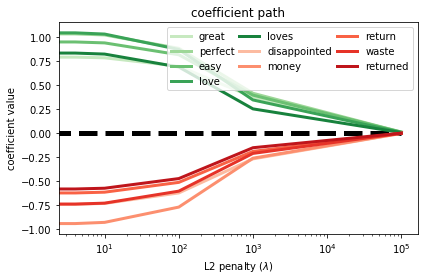

In [32]:
def make_coefficient_plot(table,positive_words,negative_words,l2_penalty_list):
    cmap_positive=plt.get_cmap('Greens')
    cmap_negative=plt.get_cmap('Reds')
    
    xx=l2_penalty_list
    plt.plot(xx,[0.0]*len(xx),'--',lw=5,color='k')
    
    table_positive_words=table[table['word'].isin(positive_words)]
    table_negative_words=table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    
    for i in range(len(positive_words)):
        color=cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx,table_positive_words[i:i+1].to_numpy().astype(float).flatten(),'-',label=positive_words[i],lw=3.0,color=color)
        
    for i in range(len(negative_words)):
        color=cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx,table_negative_words[i:i+1].to_numpy().astype(float).flatten(),'-',label=negative_words[i],lw=3.0,color=color)
                
    plt.legend(loc='best',ncol=3,prop={'size':10},columnspacing=0.5)
    #plt.axis([1,1e5,-1,2])
    plt.title('coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size':10})
    plt.tight_layout()
    
table_df=pd.DataFrame(table_of_coefficients[1:,:],columns=table_of_coefficients[0,:])
make_coefficient_plot(table_df,positive_words[:,0],negative_words[:,0],l2_penalty_list=[0,4,10,1e2,1e3,1e5])


### Accuracy

In [33]:
def accuracy(feature_matrix,coefficients,sentiments,penalty_value):
    
    score=np.dot(feature_matrix,coefficients)
    tmp7=pd.Series(score.reshape(len(score[:,0],))).apply(lambda x: +1 if x>0 else -1)
    correctclasses=0
    for i in range(len(tmp7)):
        if tmp7[i]==sentiments[i]:
            correctclasses=correctclasses+1
    accuracy=correctclasses/len(tmp7)
    print("Accuracy of penalty value",penalty_value,"coefficients is",accuracy)
    return accuracy


In [34]:
# Accuracy on training data

acc_train_0penalty= accuracy(feature_matrix_train,coefficients_0_penalty,sentiment_train,0)
acc_train_4penalty= accuracy(feature_matrix_train,coefficients_4_penalty,sentiment_train,4)
acc_train_10penalty= accuracy(feature_matrix_train,coefficients_10_penalty,sentiment_train,10)
acc_train_1e2penalty= accuracy(feature_matrix_train,coefficients_1e2_penalty,sentiment_train,1e2)
acc_train_1e3penalty= accuracy(feature_matrix_train,coefficients_1e3_penalty,sentiment_train,1e3)
acc_train_1e5penalty= accuracy(feature_matrix_train,coefficients_1e5_penalty,sentiment_train,1e5)


Accuracy of penalty value 0 coefficients is 0.7829333207716042
Accuracy of penalty value 4 coefficients is 0.7829097675295005
Accuracy of penalty value 10 coefficients is 0.7827213415926703
Accuracy of penalty value 100.0 coefficients is 0.7814259132769625
Accuracy of penalty value 1000.0 coefficients is 0.7709211672986787
Accuracy of penalty value 100000.0 coefficients is 0.6879430953670773


In [36]:
# Accuracy on test data

acc_test_0penalty= accuracy(feature_matrix_test,coefficients_0_penalty,sentiment_test,0)
acc_test_4penalty= accuracy(feature_matrix_test,coefficients_4_penalty,sentiment_test,4)
acc_test_10penalty= accuracy(feature_matrix_test,coefficients_10_penalty,sentiment_test,10)
acc_test_1e2penalty= accuracy(feature_matrix_test,coefficients_1e2_penalty,sentiment_test,1e2)
acc_test_1e3penalty= accuracy(feature_matrix_test,coefficients_1e3_penalty,sentiment_test,1e3)
acc_test_1e5penalty= accuracy(feature_matrix_test,coefficients_1e5_penalty,sentiment_test,1e5)


Accuracy of penalty value 0 coefficients is 0.7929345266132831
Accuracy of penalty value 4 coefficients is 0.7927461139896373
Accuracy of penalty value 10 coefficients is 0.7923692887423457
Accuracy of penalty value 100.0 coefficients is 0.7909561940650024
Accuracy of penalty value 1000.0 coefficients is 0.7845501648610457
Accuracy of penalty value 100000.0 coefficients is 0.6947715496938295
